## feature ranking with elimination

## In-house Recursive feature elimination

In [1]:
# # from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# # Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
# cluster = LocalCluster(n_workers=24,threads_per_worker=12,dashboard_address='0.0.0.0:8787')
# # cluster = LocalCluster(dashboard_address='0.0.0.0:8787') # Workers: 6, Cores: 24
# # cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=24,dashboard_address='0.0.0.0:8787')

# # cluster = LocalCUDACluster()
# client = Client(cluster)
# client

In [1]:
import statistics 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import statistics 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from pathlib import Path

def get_score_without_feature(X, y, features_to_drop):    
    scores = cross_val_score(XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1), X.drop(features_to_drop,axis=1), y, scoring='r2', n_jobs=-1)
    return(statistics.mean(scores))



In [2]:
def find_least_important_feature(X, y):
        
    intermediate_results = {}
    for featureindex,feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X, y, feature_name)
        intermediate_results[feature_name] = score_without_feature
        print("Getting score for: ",feature_name,score_without_feature,len(X.columns)-1)
           
    # calculate the results        
    lowest_feature = None
    lowest_score = 9999
    for feature_name in intermediate_results.keys():
        score_without_feature = intermediate_results[feature_name]
        if score_without_feature <= lowest_score:
            lowest_score = score_without_feature
            lowest_feature = feature_name
        del score_without_feature
    
    
    results = {}
    results["lowest_score"] = lowest_score
    results["lowest_feature"] = lowest_feature
    results["intermediate_results"] = intermediate_results
    return results

In [3]:
# df = pd.read_csv(input_file)
# len(df.columns.values)

In [4]:
%%time
import pickle
# classifications
# input_files = [Path("../data/original_df.csv"),Path("../data/scaled_df.csv"),Path("../data/quantile_df.csv")]   
input_files = [Path("../data/quantile_df.csv")]   
for input_file in input_files:
    print("input_file: ",input_file)
    df = pd.read_csv(input_file)
    df = df.drop(["x","y"],axis=1)

    
    y = df['target'] 
    X = df.drop("target",axis=1)
    
    min_features_required = 2
    complete_result = {}
    results = {}

    current_total_feature = X.shape[1]
    complete_result[current_total_feature] = {}

    count = 1
    print("Staring experiment for: ",X.shape[1]," features")
    results[current_total_feature] = find_least_important_feature(X,y)
    print("Results of ",str(count)," iteration:",results[current_total_feature]["lowest_score"],results[current_total_feature]["lowest_feature"])

    current_X = X.drop(results[current_total_feature]["lowest_feature"],axis=1)   
    current_total_feature = current_X.shape[1]

    count = 2
    while(current_total_feature>min_features_required):
        print("Staring experiment for: ",current_total_feature)
        results[current_total_feature] = find_least_important_feature(current_X,y)
        print("Results of ",str(count)," iteration:",results[current_total_feature]["lowest_score"],results[current_total_feature]["lowest_feature"])
        current_X = current_X.drop(results[current_total_feature]["lowest_feature"],axis=1)
        current_total_feature = current_X.shape[1]

        count = count + 1
    
    output_file_name = str(input_file.stem)+".pkl"
    print(output_file_name)
    file = open(output_file_name, 'wb')
    pickle.dump(results, file)
    file.close()

input_file:  ../data/quantile_df.csv
Staring experiment for:  42  features
Getting score for:  relief_elev_focalrange300m_3s 0.4681818170662055 41
Getting score for:  Potassium_2016 0.4666144268353729 41
Getting score for:  Grav_lane_clip 0.4505993218459566 41
Getting score for:  si_geol1 0.46445963216887554 41
Getting score for:  slope_fill2 0.46856857013231834 41
Getting score for:  Clim_Prescott_LindaGregory 0.4616724323004363 41
Getting score for:  be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata 0.46759498688604895 41
Getting score for:  relief_roughness 0.46035881640702647 41
Getting score for:  be-l8-all-85m-avg-NIR.filled.lzw.nodata 0.4556255959587467 41
Getting score for:  be-l8-all-85m-avg-BLUE.filled.lzw.nodata 0.47781594072569455 41
Getting score for:  clim_EPA_albers 0.46060473170963834 41
Getting score for:  relief_elev_focalrange1000m_3s 0.48054872017297134 41
Getting score for:  Rad2016U_Th 0.47158429084901743 41
Getting score for:  be-30y-85m-avg-SWIR2.filled.lzw.nodata 0

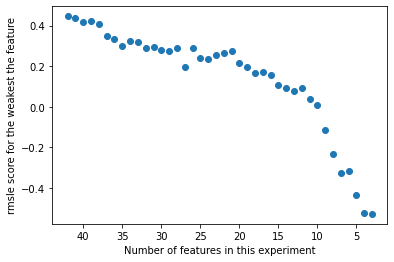

In [7]:
from matplotlib import pyplot as plt

plot_1_data = []
for exp_no in results.keys():
        plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

plt.scatter(*zip(*plot_1_data))
plt.gca().invert_xaxis()
# plt.ylim(0,0.5)
plt.xlabel("Number of features in this experiment")
plt.ylabel("rmsle score for the weakest the feature")
plt.show()

In [ ]:
#save results
import pickle

fileObj = open('complete_result_irfec.pkl', 'wb')
pickle.dump(complete_result,fileObj)
fileObj.close()

In [ ]:
## In-house Recursive feature elimination sci-kit style


## Shutdown Cluster

In [220]:
client = distributed.client._get_global_client()
client

Client Scheduler: tcp://127.0.0.1:34217 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 96 Memory: 538.97 GB


In [221]:
client.shutdown()


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
